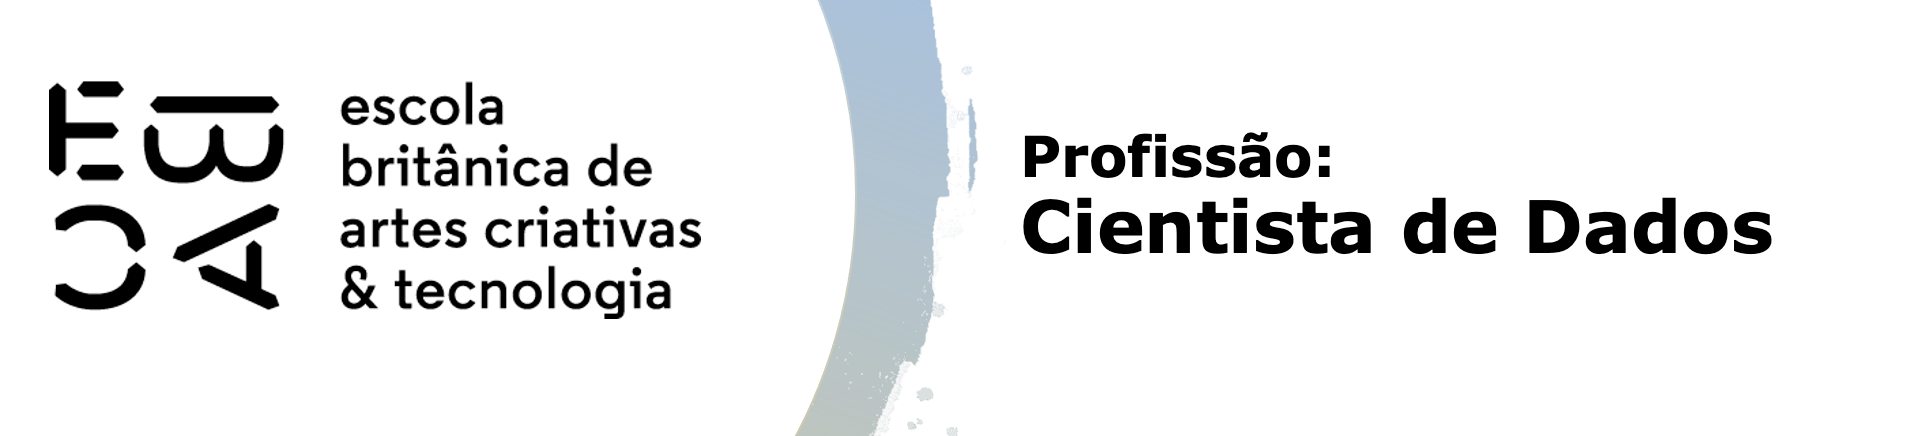

# Análise de *Clusters*

## Quantos *clusters*

Seguindo a nossa jornada nos algoritmos não supervisionados, estamos tendo contato com a quantidade de subjetividade que temos nessa temática de análise de agrupamentos. Lembre-se sempre que o objetivo do projeto deve direcionar as decisões ao longo do projeto.

Para abrir esta seção, gostaria de frisar uma frase em letras garrafais, que você deve considerar ao fazer uma análise de clusters:

**Em geral não há solução correta**. Além disso, lembre-se da frase de Box: "**Todo modelo está errado, mas alguns são úteis**". Concentre-se mais em encontrar ou melhorar a utilidade do seu agrupamento que em encontrar um "agrupamento correto" pois em geral isso não existe. Se existir, estaríamos em um método supervisionado.

Vamos nos ater agora a esta pergunta importante, ainda subjetiva, mas que ao menos possui respaldo quantitativo para auxiliar na decisão, que é **qual o número de clusters que eu devo usar?**.

Parâmetros a se considerar:

- **Objetivo de negócio**: Como sempre, o objetivo de negócio, ou o objetivo do projeto deve falar mais alto. Se a priori é factível de se trabalhar com no máximo 10 clusters, não adianta considerarmos soluções com centenas de grupos. Muitas vezes já se tem um número de clusters na cabeça, faz sentido investigar a 'melhor solução' nesse entorno.

- **Métricas quantitativas**: Vamos ver aqui algumas métricas quantitativas que nos ajudam a responder a esta pergunta. Mas embora alguns autores referenciem a técnica como "encontrar o número *ótimo* de grupos", creio que vale lembrar que há diversas métricas que clamam atingir o mesmo objetivo e que chegam a soluções diferentes. Vale também lembrar a quantidade de subjetividade que temos já na escolha das variáveis, que com decisões ligeiramente diferentes já chegamos a resultados diferentes. Dito isto, olhe as métricas como 'critérios' ou como 'referências' muito mais que 'verdades' ou 'pontos ótimos' que devem ser 'encontrados'.

- **Descrição dos grupos**: Ao descrever os grupos, eles devem fazer sentido e ser úteis com relação ao objetivo do projeto. Por exemplo, uma segmentação de clientes em um streamming de música pode ser útil para sugerir ao cliente as novidades de maior sucesso dentro do estilo que ele gosta.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [2]:
X_train = pd.read_feather('X_train.ftr')
y_train = pd.read_feather('y_train.ftr')
X_test = pd.read_feather('X_test.ftr')
y_test = pd.read_feather('X_test.ftr')
labels = pd.read_feather('labels.ftr')

y_train_cat = pd.Categorical.from_codes(codes=(y_train-1).values.flatten(),categories= labels.label)
y_train_cat.value_counts()

X_pad = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)

X_pad['y'] = y_train_cat

FileNotFoundError: [Errno 2] No such file or directory: 'X_train.ftr'

Vamos utilizar as variáveis da sessão anterior conforme o código abaixo:

In [ ]:
variaveis = ['355 fBodyAccJerk-max()-Y', '277 fBodyAcc-max()-Z',
       '509 fBodyAccMag-energy()', '183 tBodyGyroJerk-entropy()-X',
       '26 tBodyAcc-arCoeff()-X,1', '41 tGravityAcc-mean()-X']

Este foi o agrupamento que fizemos na aula anterior. Com a mesma configuração, vamos calcular uma métrica de qualidade desse agrupamento

## Método do cotovelo

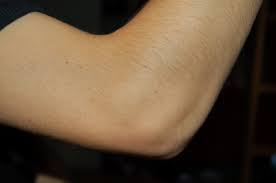


O primeiro método, também referenciado como método do 'cotovelo' (*elbow method*) é bastante popular, provavelmente por ser bastante simples e intuitivo.

Ele considera uma métrica de 'qualidade' do agrupamento como a soma de quadrados das distâncias (SSD) de cada observação ao seu respectivo centróide. Observe que essa métrica *sempre* reduz conforme aumentamos o número de clusters - até ser zero quando o número de clusters é o número de observações.

O método leva o nome de método do cotovelo pois consiste em rodar diversos *k-means* com quantidades de grupos diferentes, e calcular o respectivo SSD. Plotamos o SSD versus a quantidade de grupos, normalmente observamos uma queda mais 'brusca' no início da curva, sendo mais e mais suave conforme aumenta o K. A ideia é procurar um 'cotovelo' na curva, indicando que a redução do SSD passa a ser muito pequena conforme se aumenta o K, esse será o número de agrupamentos indicado pela técnica.

Sim, esse método é subjetivo, e sim, você pode fazer uma leitura diferente da minha. Mas como eu falei, é mais uma 'indicação'. 

In [ ]:
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(X_pad[variaveis])
    SQD.append(km.inertia_)

In [ ]:
SQD

In [ ]:
df = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
df.plot(x = 'num_clusters', y = 'SQD');

## Coeficiente de *Silueta*

<div>
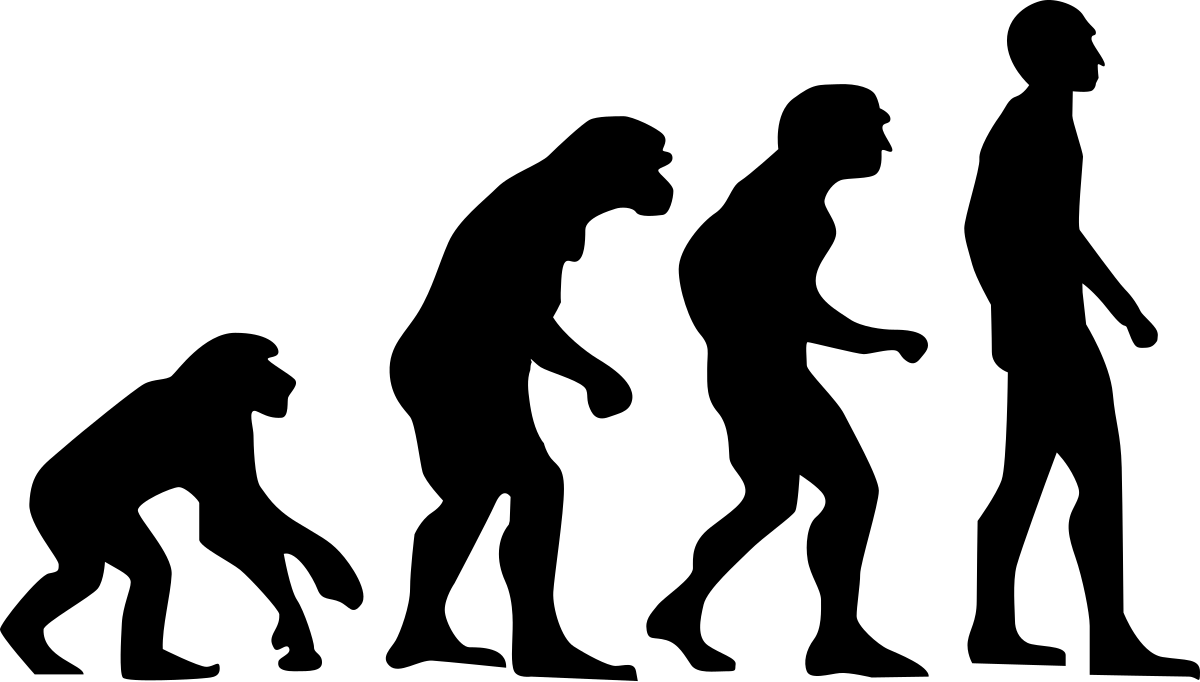
</div>

O coeficiente de Silueta (*silhouette coefficient*, traduzido livremente) é uma métrica que visa ser um pouco mais objetiva, quanto maior 'melhor', de modo que a indicação seria o número de clusters que fornece a maior silueta.

O coeficiente *Silhouette* pode ser calculado com esta fórmula:

$$ S(i) = \frac{b(i) - a(i)}{max\{a(i), b(i)\}} $$

em que:

- a(i) é a média das distâncias do ponto i a todos os pontos do grupo mais próximo exceto o seu próprio
- b(i) é a média das distâncias do ponto i a todos os demais pontos do seu grupo

Vamos utilizar a função ```silhouette_score``` para calcular a silueta média dos grupos. Esse indicador pode ainda fazer análises mais profundas, como esta no próprio [help do scikitlearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html), calculando a silhoueta por indivíduo.

## Estratégia de análise

Vamos fazer várias opções de agrupamentos, variando o número de grupos e analizar para encontrar a melhor - como fizemos com a soma de quadrados da distância.

Além de avaliar a silueta média dos indivíduos, vamos analisar os agrupamentos de forma descritiva. Vamos fazer uma visualização de dados, e vamos fazer um *biplot*, um gráfico com as duas primeiras componentes principais com a indicação das direções de variação de cada variável e a identificação dos grupos.

In [ ]:

# Inicializar uma lista vazia que vai conter os valores da silueta média
siluetas = []
# Este é o número máximo de grupos que vamos testar
max_clusters = 10

# O loop percorre de 2 até o máximo de clusters
for n_clusters in tqdm(range(2, max_clusters+1)):
    # Aqui rodamos o k-means
    km = KMeans(n_clusters=n_clusters).fit(X_pad[variaveis])
    # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
    siluetas.append(silhouette_score(X_pad[variaveis], km.labels_))
    # Essa list comprehendion define o nome dos grupos
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
    # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
    X_pad['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)


Vamos plotar agora os dados de silueta média.

In [ ]:

df_silueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silueta_média': siluetas})

df_silueta.plot.line(x = 'n_clusters', y = 'silueta_média', marker='o')
# plt.scatter(x = df_silueta.n_clusters, y = df_silueta.silueta_média)

##  Interpretando os grupos

Agora vamos fazer análises descritivas para observar a utilidade dos grupos. Essa análise é mais importante que indicadores de somas de quadrados, silueta ou qualquer outro. Nessa análise vamos tentar identificar se os grupos são diferentes, qual a característica deles e no limite, dar nomes a eles.

Podemos utilizar nesta etapa todos os recursos de visualização de dados que aprendemos. Vamos fazer alguns aqui.

Podemos analisar as variáveis que utilizamos nos agrupamentos, fazendo boxplots e gráficos de médias, e podemos validar os agrupamentos analisando variáveis que não utilizamos para treinar o algoritmo.

In [ ]:
ax = X_pad.groupby(['grupos_4', 'y'])['y'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

In [ ]:
def dataviz_grupos(varx, varg):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

    sns.boxplot(data=X_pad, y=varg, x=varx, ax=ax[0])
    sns.boxplot(data=X_pad, y='y', x=varx, ax=ax[1])
    plt.show()

dataviz_grupos(variaveis[3], 'grupos_4')

In [ ]:
padroniza = lambda x: (x - x.min())/(x.max() - x.min())

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X_pad.groupby(['grupos_4'])[variaveis].mean().apply(padroniza), 'o ')
ax.legend(variaveis, loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True)

In [ ]:
pd.crosstab(X_pad['y'], X_pad['grupos_4'])

In [ ]:
n_clusters = 4
var_grupo = 'grupos_' + str(n_clusters)
sns.pairplot(X_pad[variaveis + [var_grupo]], hue=var_grupo)

In [ ]:
pca = PCA(n_components=2)
componentes = pca.fit_transform(X_pad[variaveis])

In [ ]:
def biplot(score,coeff, y, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 2/(xs.max() - xs.min())
    scaley = 2/(ys.max() - ys.min())
    
    fig, ax = plt.subplots(figsize=(10, 10))
#     scatter = ax.scatter(xs * scalex,ys * scaley, c = y)
    sns.kdeplot(x = xs * scalex, y = ys * scaley, hue=y, ax=ax, fill=True, alpha=.6, palette='viridis')
#     ax.legend(*scatter.legend_elements())
    
    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5, 
                 length_includes_head=True, head_width=0.04, head_length=0.04)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'k', ha = 'center', va = 'center')
    ax.set_xlim(-1.2,1.2)
    ax.set_ylim(-1.2,1.2)
    ax.set_xlabel("PC{0}, {1:.1%} da variância explicada".format(1, pca.explained_variance_ratio_[0]))
    ax.set_ylabel("PC{0}, {1:.1%} da variância explicada".format(1, pca.explained_variance_ratio_[1]))
    ax.grid()


#Call the function. Use only the 2 PCs.




In [ ]:
biplot(componentes,
       np.transpose(pca.components_[0:2, :]), 
       X_pad['y'],
       labels = variaveis)
plt.show()

In [ ]:
biplot(componentes,
       np.transpose(pca.components_[0:2, :]), 
       X_pad['grupos_3'],
       labels = variaveis)
plt.show()